# Find Local Extrema of Stock Price by DMA

step:
1. find moving average (MA)

2. shift moving average left to get displaced moving average (DMA)
- displacement: MA range /2

3. find local extrema by scipy.argrelextrema


### Parameter and explain

`window = np.blackman(M)`

`M`-> extend of smoothening (how smooth to chnage the curve)
`interval` -> window to locate actual price from smoothed curve

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy.polynomial.polynomial as poly
import warnings
from scipy.signal import argrelextrema
from tabulate import tabulate
import math
import yfinance as yf

#custom modules
import stock_function as sf

In [8]:



# Download stock info
stock_info = yf.download("TSLA", start="2023-04-20", end="2023-07-21")
stock_data = pd.DataFrame(stock_info["Close"])

# stock_data

# calculate simple moving average
MA1 = 20
MA2 = 50
MA3 = 100
MA4 = 200
MA5 = 9
DISPLACEMENT1 = math.ceil(MA1/2)*(-1)
DISPLACEMENT5 = math.ceil(MA5/2)*(-1)

stock_data[f'ma{MA1}'] = stock_data['Close'].rolling(MA1).mean()
stock_data[f'ma{MA1}'].dropna(inplace=True)
stock_data[f'ma{MA2}'] = stock_data['Close'].rolling(MA2).mean()
stock_data[f'ma{MA2}'].dropna(inplace=True)
stock_data[f'ma{MA3}'] = stock_data['Close'].rolling(MA3).mean()
stock_data[f'ma{MA3}'].dropna(inplace=True)
stock_data[f'ma{MA4}'] = stock_data['Close'].rolling(MA4).mean()
stock_data[f'ma{MA4}'].dropna(inplace=True)
stock_data[f'ma{MA5}'] = stock_data['Close'].rolling(MA5).mean()
stock_data[f'ma{MA5}'].dropna(inplace=True)

stock_data[f'dma{MA1}'] = stock_data[f'ma{MA1}'].shift(DISPLACEMENT1)
stock_data[f'dma{MA3}'] = stock_data[f'ma{MA3}'].shift(math.ceil(MA3/2)*(-1))
stock_data[f"dma{MA5}"] = stock_data[f'ma{MA5}'].shift(DISPLACEMENT5)


# Calculate EMAs
stock_data['EMA9'] = stock_data['Close'].ewm(span=9, adjust=False).mean()
stock_data['EMA20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
stock_data['EMA50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()
stock_data['EMA200'] = stock_data['Close'].ewm(span=200, adjust=False).mean()

# smoothen EMA9
M=20
window = np.blackman(M)
smoothed_data = np.convolve(window/window.sum(), stock_data['EMA9'], mode='same')
smoothed_data_m1 = pd.DataFrame(smoothed_data, index=stock_data.index, columns=['smoothed EMA9-20'])

M2 = 50
window = np.blackman(M2)
smoothed_data = np.convolve(window/window.sum(), stock_data['EMA9'], mode='same')
smoothed_data_m2 = pd.DataFrame(smoothed_data, index=stock_data.index, columns=['smoothed EMA9-50'])

M3=10
window = np.blackman(M3)
smoothed_data = np.convolve(window/window.sum(), stock_data['EMA9'], mode='same')
smoothed_data_m3 = pd.DataFrame(smoothed_data, index=stock_data.index, columns=['smoothed EMA9-10'])

smoothed_data = np.convolve(window/window.sum(), stock_data['dma9'], mode='same')
smoothed_data_dma9 = pd.DataFrame(smoothed_data, index=stock_data.index, columns=['smoothed DMA9-10'])

# print(tabulate(stock_data, headers='keys', tablefmt='psql'))


[*********************100%***********************]  1 of 1 completed


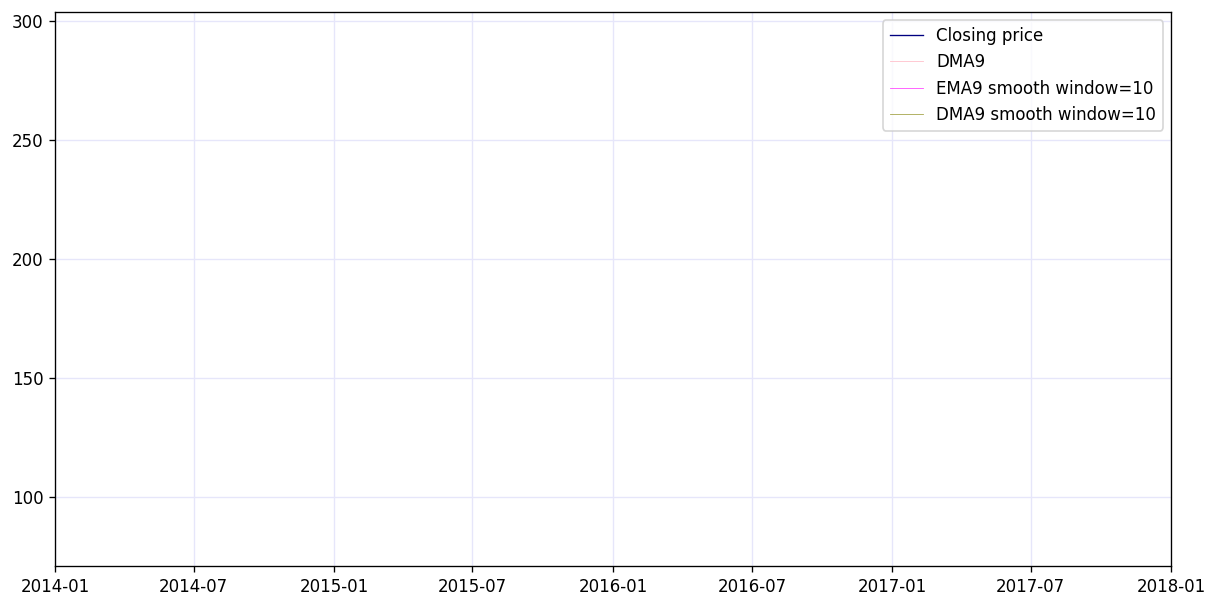

In [9]:

# plot MA
plt.figure(figsize=(12, 6), dpi=120)
plt.plot(stock_data['Close'], label="Closing price", color="navy", linewidth=0.8)
# plt.plot(stock_data[f'ma{MA1}'],  label=f"MA{MA1}",color="olive")
# plt.plot(stock_data[f'dma{MA1}'],  label=f"DMA{MA1}",color="yellow")
# plt.plot(stock_data[f'ma{MA3}'],  label=f"MA{MA3}",color="fuchsia")
plt.plot(stock_data[f'dma{MA5}'],  label=f"DMA{MA5}",color="pink", linewidth=0.5)
# # Plot EMA
# plt.figure(figsize=(24, 6), dpi=80)
# plt.plot(stock_data['Close'], label="Closing price", color="slategrey")
# plt.plot(stock_data['EMA9'], label="EMA9", color="yellow", alpha=0.8)
# plt.plot(stock_data['EMA20'], label="EMA20", color="orange", alpha=0.8)
# plt.plot(stock_data['EMA50'], label="EMA50", color="pink", alpha=1)
# plt.plot(stock_data['EMA200'], label="EMA200", color="purple", alpha=0.8)


# plt.grid(visible=True, which = 'both')
# # plt.show()




# plt.plot(smoothed_data_m2, label='EMA9 smooth window=50', color='olive', alpha=0.7, linewidth=0.5)
# plt.plot(smoothed_data_m1, label='EMA9 smooth window=20', color='yellow', linewidth=0.5)
plt.plot(smoothed_data_m3, label='EMA9 smooth window=10', color='fuchsia', alpha=0.7, linewidth=0.5)
plt.plot(smoothed_data_dma9, label='DMA9 smooth window=10', color='olive', alpha=0.7, linewidth=0.5)
plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2018-01-01'))
plt.legend()
plt.grid(which='both', color='lavender')



In [10]:
# Find local minima

def hi_get_local_extrema(original_close_data: pd.DataFrame, smoothed_data: pd.DataFrame, interval: int=5) -> pd.DataFrame:
    bottom_indexs = argrelextrema(smoothed_data.to_numpy(), np.less)[0]
    bottom_dates = []
    bottom_close = []
    for index in bottom_indexs:
        lower_boundary = index - interval
        if lower_boundary < 0:
            lower_boundary = 0
        upper_boundary = index + interval + 1
        if upper_boundary > len(original_close_data) - 1:
            upper_boundary = len(original_close_data)
        stock_data_in_interval = original_close_data.iloc[list(range(lower_boundary, upper_boundary))]
        bottom_dates.append(stock_data_in_interval.idxmin())
        bottom_close.append(stock_data_in_interval.min())
    bottoms = pd.DataFrame({"price": bottom_close, "type": 'bottom'}, index=bottom_dates)
    bottoms = bottoms[~bottoms.index.duplicated()]
    bottoms.index.name = "date"

    peak_indexes = argrelextrema(smoothed_data.to_numpy(), np.greater)[0]
    peak_dates = []
    peak_close = []
    for index in peak_indexes: #smoothed peak index
        lower_boundary = index - interval
        if lower_boundary < 0:
            lower_boundary = 0
        upper_boundary = index + interval + 1
        if upper_boundary > len(original_close_data) - 1:
            upper_boundary = len(original_close_data)
        stock_data_in_interval = original_close_data.iloc[list(range(lower_boundary, upper_boundary))]
        peak_dates.append(stock_data_in_interval.idxmax())
        peak_close.append(stock_data_in_interval.max())
    peaks = pd.DataFrame({"price": peak_close, "type": 'peak'}, index=peak_dates)
    peaks.index.name = "date"
    peaks = peaks[~peaks.index.duplicated()]
    #print(tabulate(peaks, headers='keys', tablefmt='psql'))
    print("=======")
    #print(tabulate(bottoms, headers='keys', tablefmt='psql'))


    local_extrema = pd.concat([peaks, bottoms]).sort_index()

    print("=======")
    #print(tabulate(local_extrema, headers='keys', tablefmt='psql'))
    percentage_change_lst =[np.nan]
    for i in range(1, len(local_extrema)):
        #print(local_extrema['price'][i])
        percentage_change = (local_extrema['price'][i]-local_extrema['price'][i-1])/local_extrema['price'][i-1]
        #print(percentage_change)
        percentage_change_lst.append(percentage_change)

    # pd.DataFrame({'percetage': percentage_change_lst})
    local_extrema['percentage change'] = percentage_change_lst

    return local_extrema


In [11]:


local_extrema = sf.get_local_extrema(stock_data['Close'], smoothed_data_dma9, 5)


print(tabulate(local_extrema, headers='keys', tablefmt='psql', floatfmt=(None,".2f", None, ".2%")))

+---------------------+---------+--------+---------------------+
| date                |   price | type   |   percentage change |
|---------------------+---------+--------+---------------------|
| 2023-06-20 00:00:00 |  274.45 | peak   |                nan% |
| 2023-06-26 00:00:00 |  241.05 | bottom |             -12.17% |
+---------------------+---------+--------+---------------------+


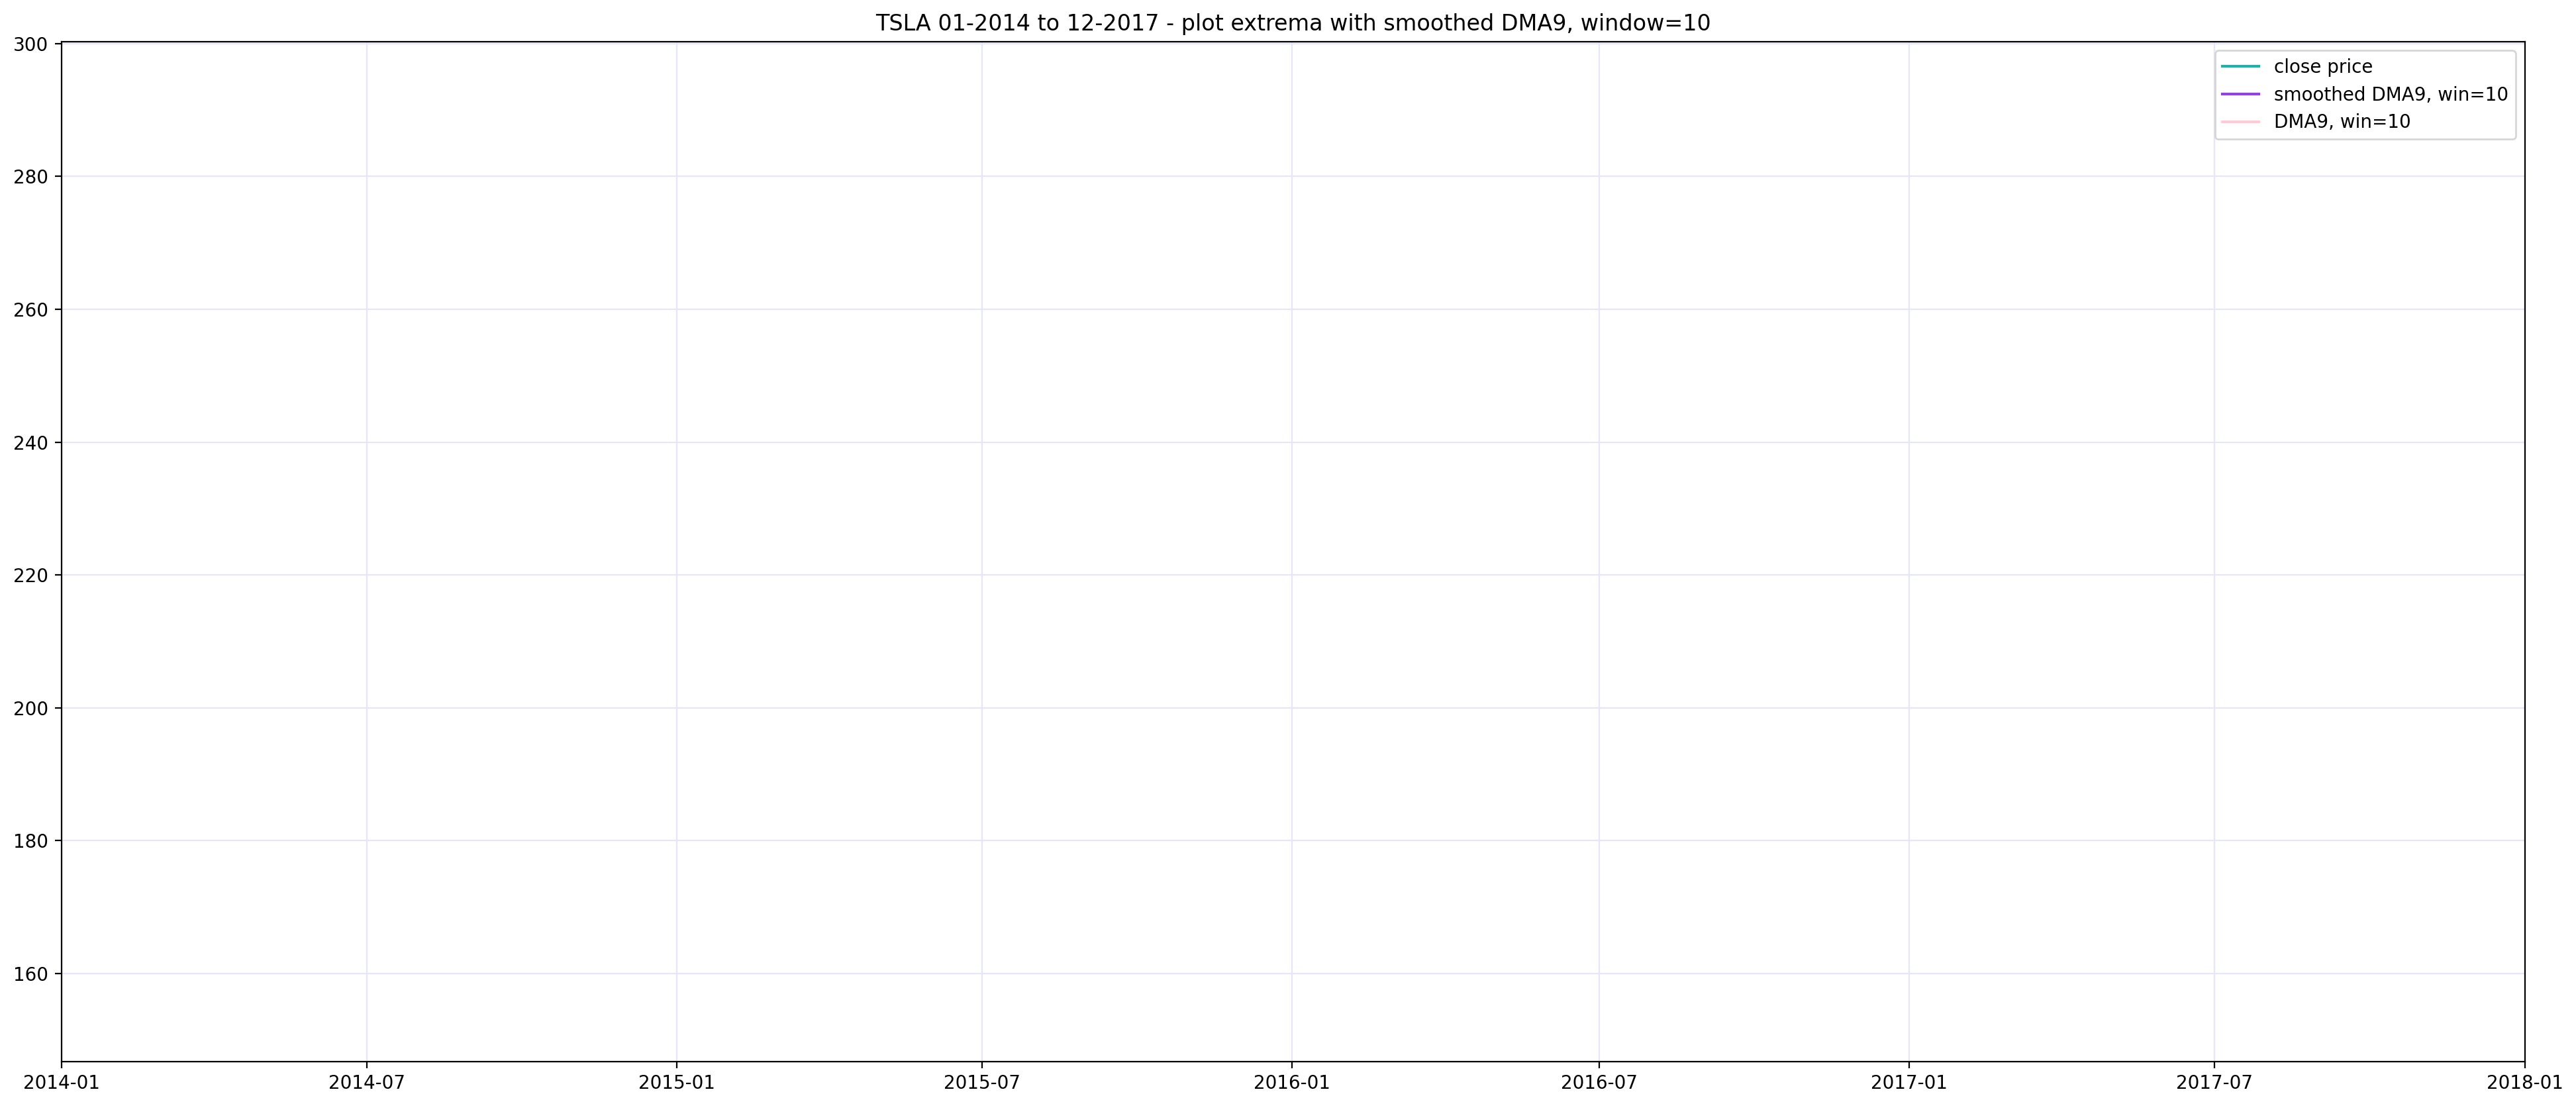

In [12]:
plt.figure(figsize=(24, 10), dpi=200)
plt.plot(stock_data['Close'], label='close price', color='lightseagreen')
plt.plot(smoothed_data_dma9, label='smoothed DMA9, win=10' ,color='blueviolet', alpha=0.9)
plt.plot(stock_data['dma9'], label='DMA9, win=10' ,color='pink', alpha=0.8)


plt.plot(local_extrema['price'], "x", color='red')
for date, extrema, percent in zip(local_extrema.index, local_extrema['price'], local_extrema['price']):
    plt.annotate("{:.2f}".format(extrema)
                 + ", {:.2%}".format(percent), (date, extrema), fontsize=6)
plt.annotate("plot extrema with smoothed DMA9, window=10",(100,100))
plt.legend()


plt.grid(which='major', color='lavender')
plt.grid(which='minor', color='lavender')
plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2018-01-01'))
plt.title('TSLA 01-2014 to 12-2017 - plot extrema with smoothed DMA9, window=10')
plt.show()